# Over/Under - Evaluating our Edge
- In this notebook, we repeat the evaluation of the over/under model but with a larger test set
- We will then do some simulations to see what kinds of profit we could expect (assuming our edge is real)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import structureboost as stb
import ml_insights as mli
import scipy as sp

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [3]:
df=pd.read_csv('Data/df_bp9.csv')
df_runs=pd.read_csv('Data/df_runs_bp11.csv')

/tmp/ipykernel_118976/145339343.py:1: DtypeWarning: Columns (13,14,15,19,85,87,159,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Data/df_bp9.csv')
/tmp/ipykernel_118976/145339343.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_runs=pd.read_csv('Data/df_runs_bp11.csv')


In [4]:
df.over_under_line.max()

15.0

In [5]:
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],16)

In [6]:
# Let's modify this part to make the test set bigger

df_train = df_runs[(df_runs.season>1980) & (df_runs.season<=2017) & ~(df_runs.OBP_162.isnull())]
df_valid = df_runs[(df_runs.season>=2018) & (df_runs.season<=2018)]
df_test = df_runs[df_runs.season>=2019]

df_test_game = df[df.season>=2019]

In [7]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_35',
 'Strt_TB_BB_perc_35',
 'Strt_H_BB_perc_35',
 'Strt_SO_perc_10',
 'Bpen_WHIP_75',
 'Bpen_TB_BB_perc_75',
 'Bpen_H_BB_perc_75',
 'Bpen_SO_perc_75',
 'Bpen_WHIP_35',
 'Bpen_TB_BB_perc_35',
 'Bpen_H_BB_perc_35',
 'Bpen_SO_perc_35',
 'Bpen_WHIP_10',
 'Bpen_TB_BB_perc_10',
 'Bpen_H_BB_perc_10',
 'Bpen_SO_perc_10',
 'lineup9_OBP_162',
 'lineup9_SLG_162',
 'home_hitting']

In [8]:
bpv2 = np.linspace(-.5,16.5,18)
bpv2

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5])

In [9]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [10]:
cr1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', 
               binpt_vec=bpv2)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.449938013686902
i=10, eval_set_loss = 2.447121568647858
i=20, eval_set_loss = 2.444903719234528
i=30, eval_set_loss = 2.443310371897049
i=40, eval_set_loss = 2.442086801023038
i=50, eval_set_loss = 2.4411771158061444
i=60, eval_set_loss = 2.4405058635853036
i=70, eval_set_loss = 2.4399452554365437
i=80, eval_set_loss = 2.439461788452456
i=90, eval_set_loss = 2.4390500826530754
i=100, eval_set_loss = 2.438722461690322
i=110, eval_set_loss = 2.438569638979661
i=120, eval_set_loss = 2.4384201469286766
i=130, eval_set_loss = 2.438202907445464
i=140, eval_set_loss = 2.4379587152407343
i=150, eval_set_loss = 2.4378941248501214
i=160, eval_set_loss = 2.4378485800657606
i=170, eval_set_loss = 2.4377763709543605
i=180, eval_set_loss = 2.4377608339843237
i=190, eval_set_loss = 2.4377702947246416
i=200, eval_set_loss = 2.437739732863579
i=210, eval_set_loss = 2.4376991884918557
i=220, eval_set_loss = 2.437742296439856
i=230, eval_set_loss = 2.437835966873562
i=240, eval_set

In [11]:
preds_test = cr1.predict_distributions(X_test)
preds_test.log_loss(y_test)

2.4495449513190737

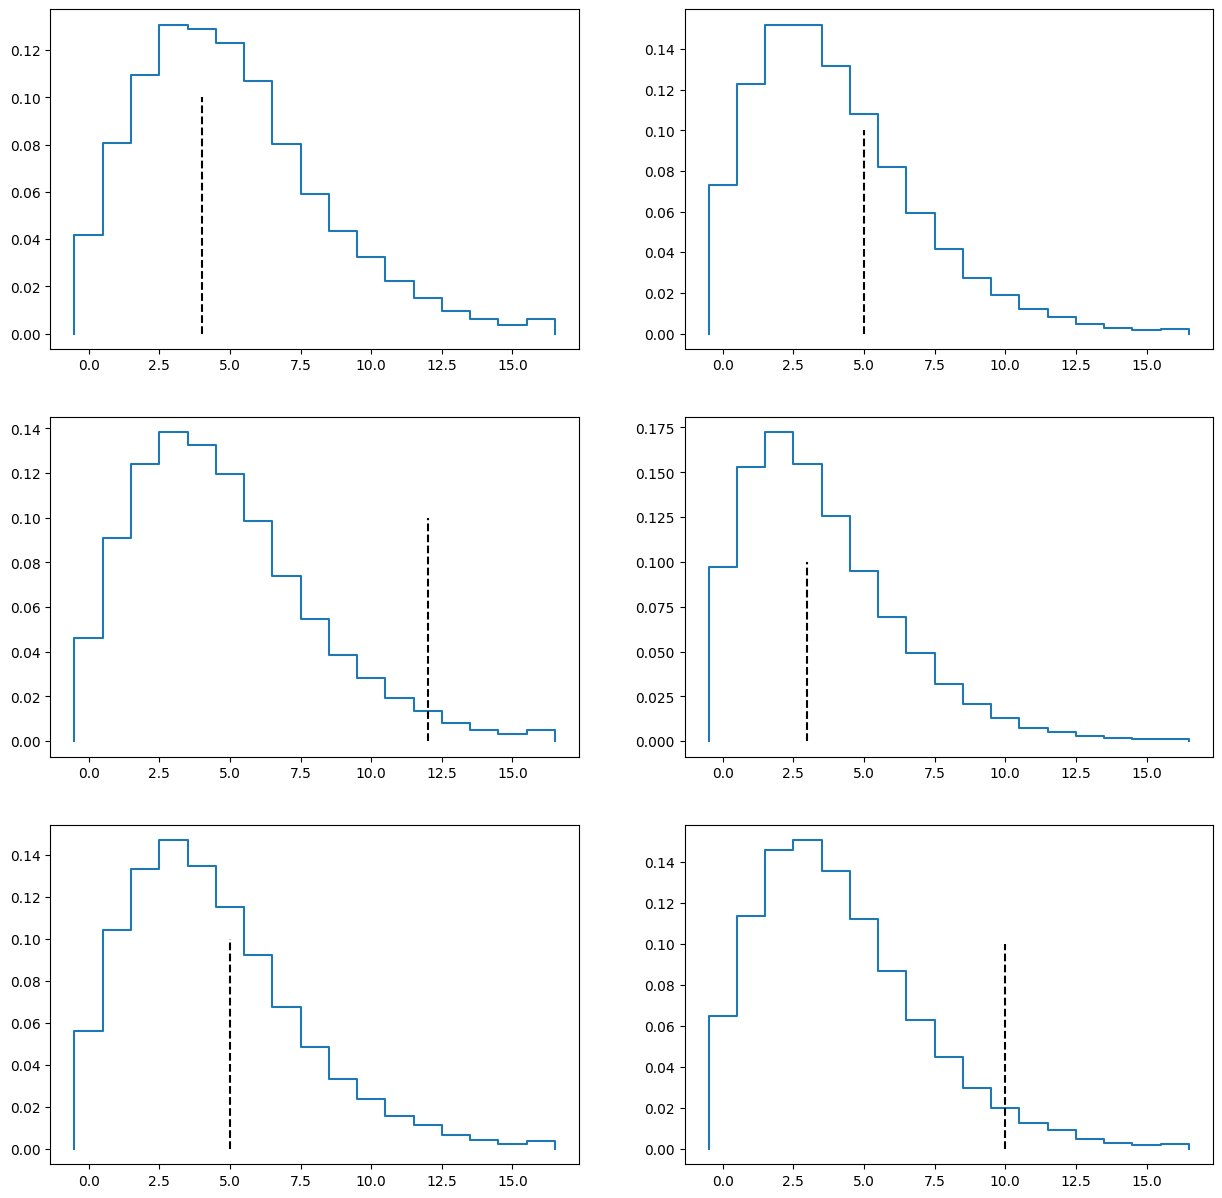

In [12]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    preds_test[i].plot_density()
    plt.vlines(x=y_test[i], ymin=0,ymax=.1, color='k', linestyle='--')

# Predicting the Over / Under
As a first step, we will model the total score as an independent sum of the two scores. 

For baseball, this is not a terrible assumption (would be worse in other sports)
Still, would expect some imperfection, since teams make strategic decisions based on the score of the game
- Play for one run in a close game
- Put a rookie pitcher in with a big lead

In [13]:
def probs_oup_val(probvec_a, probvec_b, val, ties_go_over=True):
    """given two probability distributions and the ou-line, returns prob of under"""
    val_up = int(np.ceil(val))
    val_down = int(np.floor(val))
    cdf_b = np.cumsum(probvec_b)
    prob_under = 0
    prob_push = 0
    if (val_down<val_up): # This means we have a decimal (.5) o/u value - no pushes      
        for i in range(0, val_down+1):
            # calculate prob that we are less than or equal to val_down for each
            # value of probvec_a between 0 and val_down
            prob_under += probvec_a[i] * cdf_b[val_down-i]
        return(1-prob_under-prob_push, prob_under, prob_push)
    else: # This means val_down == val_up == val and we have an integer line so pushes are possible
        for i in range(0, val_down):
            # calculate prob that we are less than or equal to val_down-1 for each
            # value of probvec_a between 0 and val_down
            prob_under += probvec_a[i] * cdf_b[val_down-1-i]
        for j in range(0, val_down+1):
            # calculate prob that we are exactly = val_down
            if (not ties_go_over) or (j != val_down-j): # if line is 10 and predicts score of 5-5, maybe count as over
                prob_push += probvec_a[j] * probvec_b[val_down-j] 
        return(1-prob_under-prob_push, prob_under,  prob_push)

In [14]:
num_games_test=int(df_test.shape[0]/2)

oup_probs = np.array([probs_oup_val(preds_test[i].probvec, preds_test[i+num_games_test].probvec, df_test.over_under_line.iloc[i])
                        for i in range(num_games_test)])

In [15]:
oup_probs.mean(axis=0)

array([0.43588257, 0.52361129, 0.04050614])

In [16]:
df_test.over_under_result.value_counts().sum(), df_test.over_under_result.value_counts()/df_test.over_under_result.value_counts().sum()

(16358,
 over_under_result
 U    0.482333
 O    0.468639
 P    0.049028
 Name: count, dtype: float64)

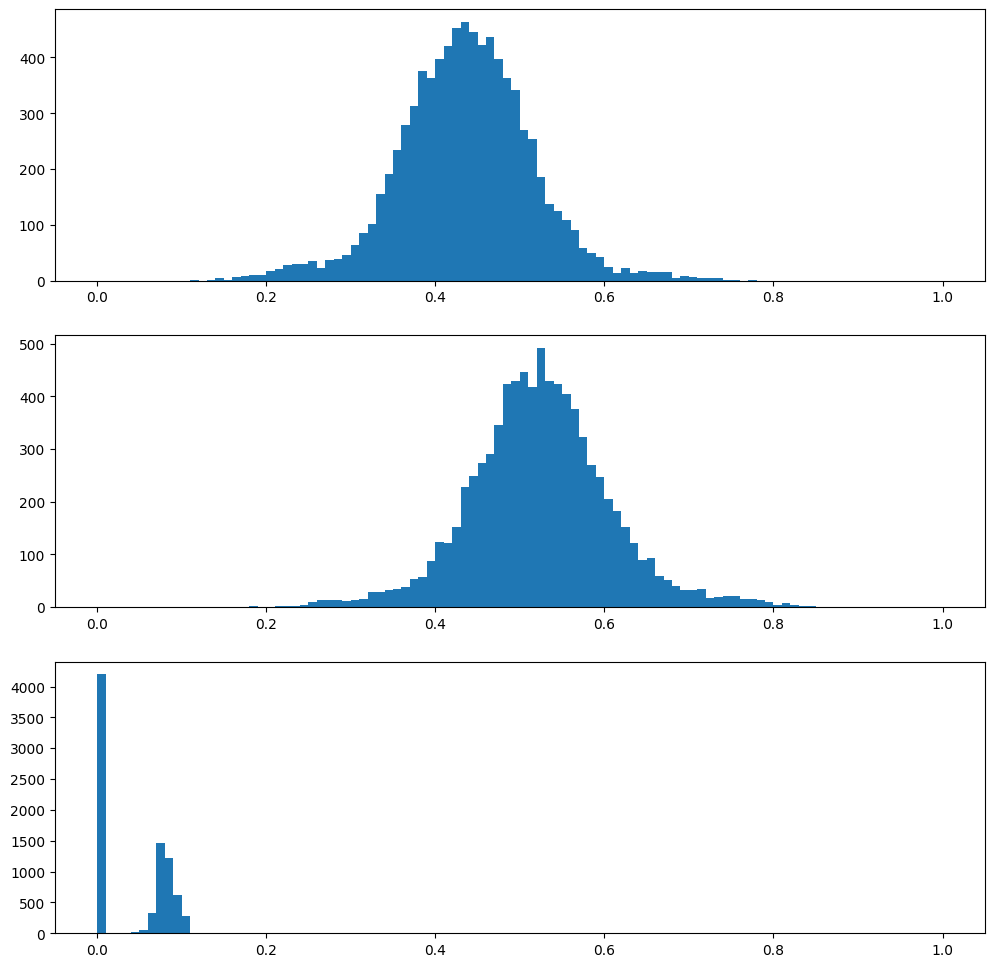

In [17]:
plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
plt.hist(oup_probs[:,0], np.linspace(0,1,101));
plt.subplot(3,1,2)
plt.hist(oup_probs[:,1], np.linspace(0,1,101));
plt.subplot(3,1,3)
plt.hist(oup_probs[:,2], np.linspace(0,1,101));

In [18]:
def evaluate_edge_probs(oupmat, edge, test_df_w_ouline):
    bet_under = (oupmat[:,1]/(oupmat[:,0] + oupmat[:,1])) > (.5 + edge)
    bet_over = (oupmat[:,0]/(oupmat[:,0] + oupmat[:,1])) > (.5 + edge)
    
    num_cases_under = np.sum(bet_under)
    num_cases_over = np.sum(bet_over)
    num_cases_total = num_cases_under + num_cases_over
    
    num_under_correct = (test_df_w_ouline.loc[bet_under,'over_under_result']=='U').sum()
    num_under_push = (test_df_w_ouline.loc[bet_under,'over_under_result']=='P').sum()
    num_over_correct = (test_df_w_ouline.loc[bet_over,'over_under_result']=='O').sum()
    num_over_push = (test_df_w_ouline.loc[bet_over,'over_under_result']=='P').sum()
    
    num_correct = num_under_correct + num_over_correct
    num_pushes = num_under_push + num_over_push
    num_incorrect = num_cases_total -num_correct - num_pushes
    
    pct_correct = num_correct / num_cases_total
    pct_pushes = num_pushes / num_cases_total
    pct_incorrect = num_incorrect / num_cases_total
    pct_under_correct = num_under_correct/num_cases_under
    pct_under_push = num_under_push/num_cases_under
    pct_over_correct = num_over_correct/num_cases_over
    pct_over_push = num_over_push/num_cases_over
    
    print(f'\nThere were {num_cases_total} games that met criteria of edge > {edge} ({num_cases_under} unders and {num_cases_over} overs)')
    print(f'Of them {num_correct} ({np.round(pct_correct,3)}) were correct (winning bets), ({num_under_correct} unders and {num_over_correct} overs) ')
    print(f'and {num_pushes} ({np.round(pct_pushes,3)}) were Pushes ({num_under_push} unders and {num_over_push} overs)')
    print(f'and {num_incorrect} ({np.round(pct_incorrect,3)}) were incorrect (losing bets))')
    
    winning_edge_m110 = pct_correct*1 + pct_incorrect*(-1.1)
    win_total_m110 = num_correct*1 + num_incorrect*(-1.1)
    
    print(f'Betting the Under at a line of -110, your profit would have been {np.round(winning_edge_m110,4)} per bet')
    print(f'\t for a total profit of {np.round(win_total_m110,2)} across all {num_cases_total} bets')
    print('\n')
    

In [19]:
for i in np.linspace(.25, .05,5):
    print(f'threshold = {i}')
    evaluate_edge_probs(oup_probs, i, df_test_game)

threshold = 0.25

There were 164 games that met criteria of edge > 0.25 (153 unders and 11 overs)
Of them 89 (0.543) were correct (winning bets), (84 unders and 5 overs) 
and 7 (0.043) were Pushes (5 unders and 2 overs)
and 68 (0.415) were incorrect (losing bets))
Betting the Under at a line of -110, your profit would have been 0.0866 per bet
	 for a total profit of 14.2 across all 164 bets


threshold = 0.2

There were 360 games that met criteria of edge > 0.2 (304 unders and 56 overs)
Of them 198 (0.55) were correct (winning bets), (166 unders and 32 overs) 
and 18 (0.05) were Pushes (12 unders and 6 overs)
and 144 (0.4) were incorrect (losing bets))
Betting the Under at a line of -110, your profit would have been 0.11 per bet
	 for a total profit of 39.6 across all 360 bets


threshold = 0.15

There were 823 games that met criteria of edge > 0.15 (687 unders and 136 overs)
Of them 421 (0.512) were correct (winning bets), (353 unders and 68 overs) 
and 37 (0.045) were Pushes (30 unde

In [20]:
def evaluate_lkratio(nc, ni, null_prob, alt_prob):
    null_lk = sp.stats.binom.pmf(nc,nc+ni,null_prob)
    alt_lk = sp.stats.binom.pmf(nc,nc+ni,alt_prob)
    return(alt_lk/null_lk)

In [21]:
evaluate_lkratio(89, 68, .5, 89/(80+68))

2.7814252013569565

In [22]:
evaluate_lkratio(198, 144, .5, 198/(198+144))

72.31639685196194

In [23]:
evaluate_lkratio(421, 365, .5, 421/(421+365))

7.363991496660199

In [24]:
evaluate_lkratio(1018, 974, .5, 1018/(1018+974))

1.6257728419461082

In [25]:
def_prob = 0.482333/(0.482333+0.468639)
def_prob

0.5072000016824891

In [26]:
evaluate_lkratio(198, 144, def_prob, 198/(198+144))

34.42762208749042

In [27]:
mid_prob = (def_prob+(198/(198+144)))/2
mid_prob

0.5430736850517709

In [28]:
198/(198+144)

0.5789473684210527

In [29]:
evaluate_lkratio(198, 144, def_prob, mid_prob)

14.119250263588178

# Let's simulate the future
Assume we can be "right" 57.8% of the time
- How much can we expect to make betting for an entire season?
- How likely is it that we would lose money?

In [30]:
df_test_game.season.value_counts()

season
2019    2429
2022    2427
2021    2425
2020     898
Name: count, dtype: int64

In [32]:
pct_games_to_bet = 360/16358
num_games_in_season = 2430
pct_games_to_bet, pct_games_to_bet*num_games_in_season

(0.022007580388800588, 53.47842034478543)

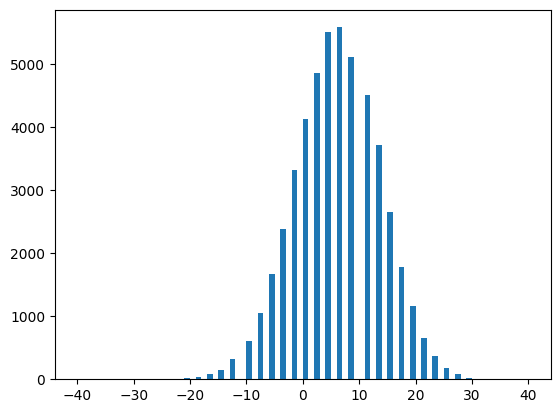

In [33]:
num_games_bet = 53
betting_wins = np.random.binomial(n=num_games_bet, p=.578, size=50000)
betting_losses = num_games_bet-betting_wins
amount_won = betting_wins -1.1*betting_losses
plt.hist(amount_won, np.linspace(-40,40,81));

In [34]:
np.mean(amount_won<0)

0.19262

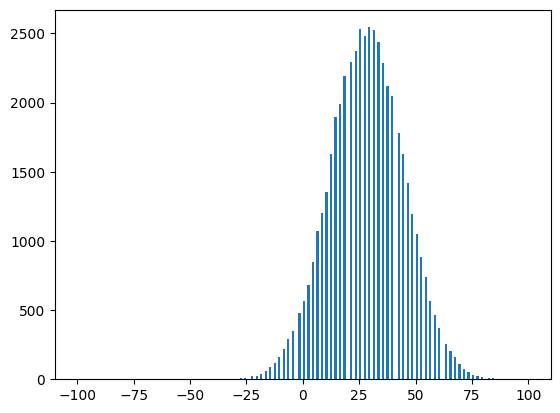

In [35]:
num_games_bet = 250
betting_wins = np.random.binomial(n=num_games_bet, p=.578, size=50000)
betting_losses = num_games_bet-betting_wins
amount_won = betting_wins -1.1*betting_losses
plt.hist(amount_won, np.linspace(-100,100,201));

In [36]:
np.mean(amount_won<0)

0.03754

# Conclusions

Profit is small relative to the amounts bet
- Even with edge, still reasonable chance of losing money!
- Good news - this was our first stab at a model! Lots of ways to improve
- Bad news - potential that this model could be off (rule changes, etc)

# Next Steps

- Explore calibration / validity of team level run-prediction
- Build model for Under/Over/Push rather than relying on independence assumption (make features out of the probability distributions)
- Generally improve runs scored model (feature selection, hyper-parameter tuning, etc.)
- Use the runs scored model to develop features for predicting the winner (against moneyline)
- Predict run "differential" and use that to predict winner (against moneyline)
- See if runs scored models can help us bet on the spread (like point spreads in football)
